<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Barabasi-Albert" data-toc-modified-id="Barabasi-Albert-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Barabasi Albert</a></span></li><li><span><a href="#Erdos-renyi" data-toc-modified-id="Erdos-renyi-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Erdos-renyi</a></span></li><li><span><a href="#Small-world" data-toc-modified-id="Small-world-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Small world</a></span></li></ul></div>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prody import *
import logging
import seaborn as sns
from scipy.stats import pearsonr
from itertools import chain
import os
from scipy.stats import spearmanr
import time
import sqlalchemy as sql
import pymysql
import itertools as itr
from datetime import datetime
from mlxtend.evaluate import permutation_test
import pickle
import random
from tqdm import tqdm

#%load_ext rpy2.ipython
%matplotlib inline
from func import *
from matplotlib.lines import Line2D
figsize=(8,8)
#plt.rcParams["figure.figsize"] = figsize
logger = logging.getLogger()
logging.disable()

params = {'legend.fontsize': 'x-large',
          'figure.figsize': figsize,
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [171]:
def get_gnm_df(Gc):
    L = nx.laplacian_matrix(Gc, weight=None).todense()
    adj = nx.adjacency_matrix(Gc).todense()
    #d = np.diag(L)
    nodes = [_ for _ in Gc.nodes()]
    degree = [deg for id, deg in list(Gc.degree)]
    clustering_coeff = list((nx.clustering(Gc)).values())
    gnm = GNM()
    gnm.setKirchhoff(L)

    gnm.calcModes(n_modes=None, zeros=False)
    gnm.nodes = nodes
    gnm.degrees = degree
    #showCrossCorr(gnm)
    sqf_orig = calcSqFlucts(gnm)
    coll = calcCollectivity(gnm)
    coll_nonnormal= [i * len(gnm.nodes) for i in coll]

    prs_mat, eff_orig_avg, sens_orig_avg = calcPerturbResponse(gnm, suppress_diag=True)
    df = pd.DataFrame()
    df['orf_name']=nodes
    df['deg']=degree
    coll_index_sorted = sorted(range(len(coll)), key=lambda k: coll[k], reverse=True)
    eff_orig = np.sum(prs_mat, axis=1)
    sens_orig = np.sum(prs_mat, axis=0)
    eigvecs_df = pd.DataFrame(gnm.getEigvecs()[:,coll_index_sorted[:100]])

    df_ = pd.merge(df,eigvecs_df,left_index=True,right_index=True)
    df_['eff'] = eff_orig
    df_['sens'] = sens_orig
    eigenvector_centr = nx.eigenvector_centrality_numpy(Gc)
    closeness_centr = nx.closeness_centrality(Gc)
    df_['btw']= betweenness_nx(Gc,normalized=True)
    df_['trans']= list((nx.clustering(Gc)).values())
    df_['eigenvec_centr'] = [eigenvector_centr[i] for i in eigenvector_centr]
    df_['closeness_centr'] = [closeness_centr[i] for i in closeness_centr]
    
    return df_, gnm, prs_mat
def sequential_deletion(Gc,df_):
    deg_sorted_deletion = {'num_of_comp':[], 'gc_size':[]}
    hinge_sorted_deletion= {'num_of_comp':[], 'gc_size':[]}
    rand_deletion =  {'num_of_comp':[], 'gc_size':[]}
    btw_sorted_deletion =  {'num_of_comp':[], 'gc_size':[]}
    eff_sorted_deletion= {'num_of_comp':[], 'gc_size':[]}
    hinge_sorted_deletion_rev= {'num_of_comp':[], 'gc_size':[]}
    sens_sorted_deletion =  {'num_of_comp':[], 'gc_size':[]}
    eigenvec_centr_sorted_deletion =  {'num_of_comp':[], 'gc_size':[]}
    closeness_centr_sorted_deletion =  {'num_of_comp':[], 'gc_size':[]}
    sens_sorted_deletion_rev =  {'num_of_comp':[], 'gc_size':[]}

    rand_nodes = random.sample([n for n in Gc.nodes],len(Gc.nodes)-1)
    range_ = range(0,len(Gc.nodes)-1,10)
    #m#ax_node_num_rand_hinge_comp_list = [ ]
    for i in tqdm(range_):
        #degree
        network_chance_deletion(df_.sort_values('deg',ascending=False).iloc[0:i,0].tolist(), Gc, deg_sorted_deletion)


        #eigenvec_hinge
        network_chance_deletion(df_.reindex(df_[0].abs().sort_values().index).iloc[0:i,0].tolist(), Gc, hinge_sorted_deletion)

        #random
        network_chance_deletion(rand_nodes[0:i], Gc, rand_deletion)

        #effectiveness
        network_chance_deletion(df_.reindex(df_['eff'].abs().sort_values(ascending=False).index).iloc[0:i,0].tolist(), Gc, eff_sorted_deletion)

        #eigenvec_hinge descending
        network_chance_deletion(df_.reindex(df_[0].abs().sort_values(ascending=False).index).iloc[0:i,0].tolist(), Gc, hinge_sorted_deletion_rev)

        #sensitivity
        network_chance_deletion(df_.reindex(df_['sens'].abs().sort_values(ascending=False).index).iloc[0:i,0].tolist(), Gc, sens_sorted_deletion)

        #sensitivity rev
        network_chance_deletion(df_.reindex(df_['sens'].abs().sort_values(ascending=True).index).iloc[0:i,0].tolist(), Gc, sens_sorted_deletion_rev)

        #betweenness
        network_chance_deletion(df_.reindex(df_['btw'].abs().sort_values(ascending=False).index).iloc[0:i,0].tolist(), Gc,btw_sorted_deletion)

        #eigenvector centrality
        network_chance_deletion(df_.reindex(df_['eigenvec_centr'].abs().sort_values(ascending=False).index).iloc[0:i,0].tolist(), Gc,eigenvec_centr_sorted_deletion)

        #closeness
        network_chance_deletion(df_.reindex(df_['closeness_centr'].abs().sort_values(ascending=False).index).iloc[0:i,0].tolist(), Gc,closeness_centr_sorted_deletion)

    dd = {'deg_sorted_deletion':deg_sorted_deletion,
     'hinge_sorted_deletion':hinge_sorted_deletion,
     'rand_deletion':rand_deletion,
     'eff_sorted_deletion':eff_sorted_deletion,
     'sens_sorted_deletion':sens_sorted_deletion,
     'btw_sorted_deletion':btw_sorted_deletion,
     'hinge_sorted_deletion_rev':hinge_sorted_deletion_rev,
          'closeness_centr_sorted_deletion':closeness_centr_sorted_deletion,
          'sens_sorted_deletion_rev':sens_sorted_deletion_rev,
          'eigenvec_centr_sorted_deletion':eigenvec_centr_sorted_deletion,
        'range':range_}
    return dd

def plot_sequential_deletion_num_of_comp(dd, title='Sequential deletion'):
    
    plt.plot(dd['range'],dd['deg_sorted_deletion']['num_of_comp'],c='b',label='Degree')
    plt.plot(dd['range'],dd['hinge_sorted_deletion']['num_of_comp'],c='r',label='Hinge')
    plt.plot(dd['range'],dd['rand_deletion']['num_of_comp'],c='g',label='Random')
    plt.plot(dd['range'],dd['eff_sorted_deletion']['num_of_comp'],c='y',label='Effectiveness')
    plt.plot(dd['range'],dd['hinge_sorted_deletion_rev']['num_of_comp'],c='c',label='Hinge reversed')
    plt.plot(dd['range'],dd['sens_sorted_deletion']['num_of_comp'],c='k',label='Sensitivity')
    plt.plot(dd['range'],dd['btw_sorted_deletion']['num_of_comp'],c='m',label='Betweenness')
    plt.plot(dd['range'],dd['eigenvec_centr_sorted_deletion']['num_of_comp'],c='darkviolet',label='Eigenvector Centr')
    plt.plot(dd['range'],dd['closeness_centr_sorted_deletion']['num_of_comp'],c='pink',label='Closeness Centr')
    plt.plot(dd['range'],dd['sens_sorted_deletion_rev']['num_of_comp'],c='dimgray',label='Sensitivity Reversed')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 0.5),loc='center left')
    plt.xlabel('Number of deleted nodes')
    plt.ylabel('Number of connected components')
    #plt.savefig('figures/num_of_comp_deletion.png',width=16,height=12)
    #
    
def plot_sequential_deletion_gc_size(dd, title='Sequential deletion'):
    fig, ax = plt.subplots()
    plt.plot(dd['range'],dd['deg_sorted_deletion']['gc_size'],c='b',label='Degree')
    plt.plot(dd['range'],dd['hinge_sorted_deletion']['gc_size'],c='r',label='Hinge')
    plt.plot(dd['range'],dd['rand_deletion']['gc_size'],c='g',label='Random')
    plt.plot(dd['range'],dd['eff_sorted_deletion']['gc_size'],c='y',label='Effectiveness')
    plt.plot(dd['range'],dd['hinge_sorted_deletion_rev']['gc_size'],c='c',label='Hinge reversed')
    plt.plot(dd['range'],dd['sens_sorted_deletion']['gc_size'],c='k',label='Sensitivity')
    plt.plot(dd['range'],dd['btw_sorted_deletion']['gc_size'],c='m',label='Betweenness')
    plt.plot(dd['range'],dd['eigenvec_centr_sorted_deletion']['gc_size'],c='darkviolet',label='Eigenvector Centr')
    plt.plot(dd['range'],dd['closeness_centr_sorted_deletion']['gc_size'],c='pink',label='Closeness Centr')
    plt.plot(dd['range'],dd['sens_sorted_deletion_rev']['gc_size'],c='dimgray',label='Sensitivity Reversed')
    plt.title(title)

    plt.legend(bbox_to_anchor=(1, 0.5),loc='center left')
    plt.xlabel('Number of deleted nodes')
    plt.ylabel('Giant component size')
    #plt.savefig('figures/gc_size_deletion.png',width=16,height=12)

In [ ]:
ba = nx.barabasi_albert_graph(1000,2)
er = nx.erdos_renyi_graph(1000,0.05)
sw = nx.connected_watts_strogatz_graph(1000,100,0.9)

In [ ]:
ba_df, ba_gnm, ba_prs_mat = get_gnm_df(ba)
er_df, er_gnm, er_prs_mat = get_gnm_df(er)
sw_df, sw_gnm, sw_prs_mat = get_gnm_df(sw)

# Barabasi Albert

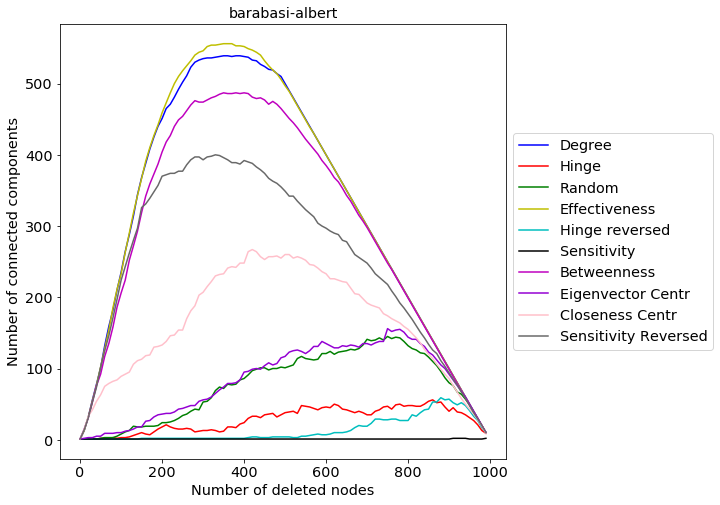

In [158]:
plot_sequential_deletion_num_of_comp(dd_ba,'barabasi-albert')

In [168]:
ba_df.loc[:,['deg','eff']].corr(method='spearman')

,deg,eff
deg,1.00000,0.91199
eff,0.91199,1.00000


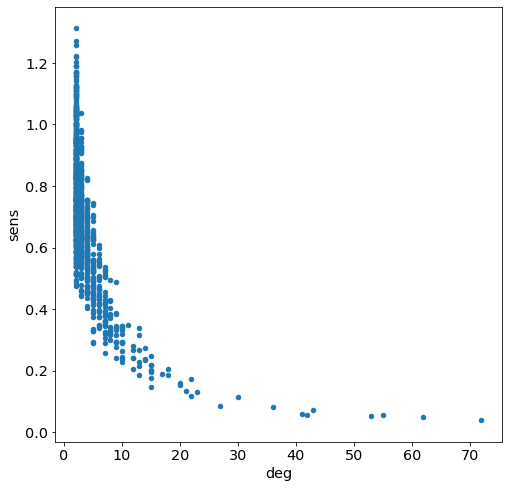

In [164]:
ba_df.plot.scatter('deg','sens')

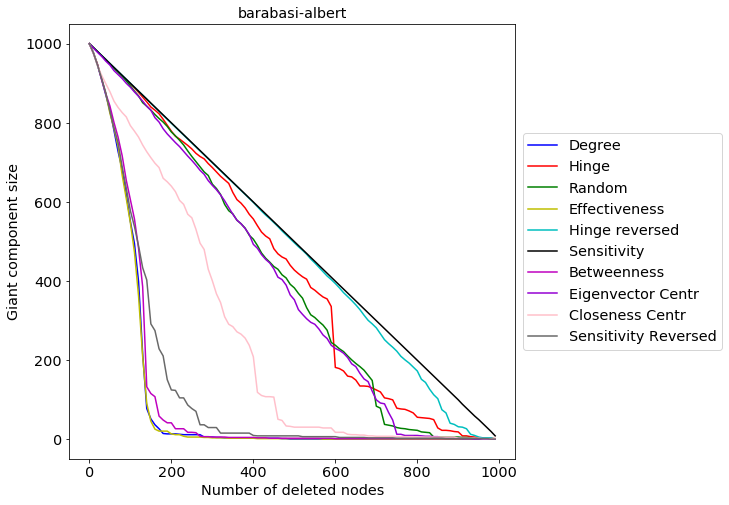

In [159]:
plot_sequential_deletion_gc_size(dd_ba,'barabasi-albert')

# Erdos-renyi

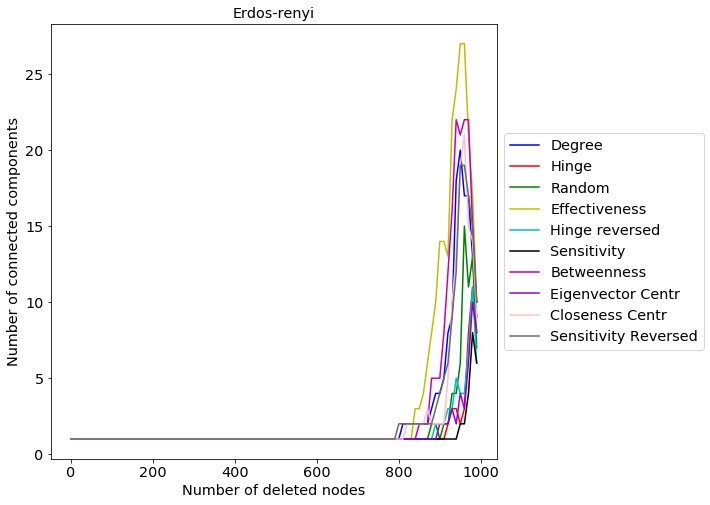

In [160]:
plot_sequential_deletion_num_of_comp(dd_er,'Erdos-renyi')

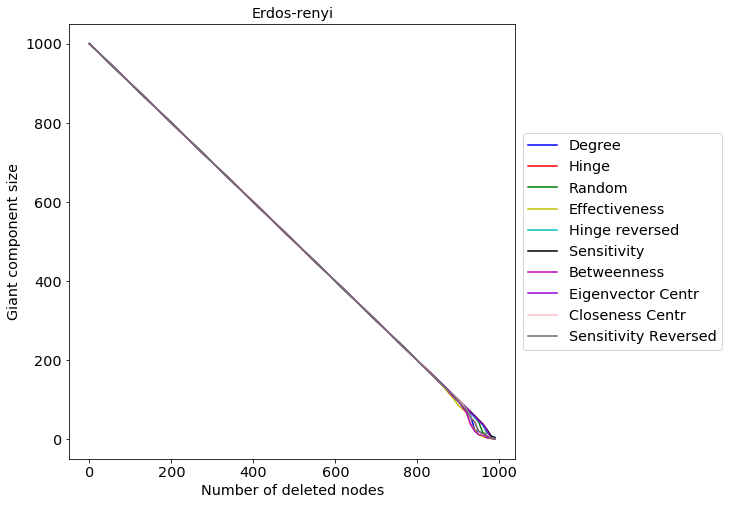

In [161]:
plot_sequential_deletion_gc_size(dd_er,'Erdos-renyi')

# Small world

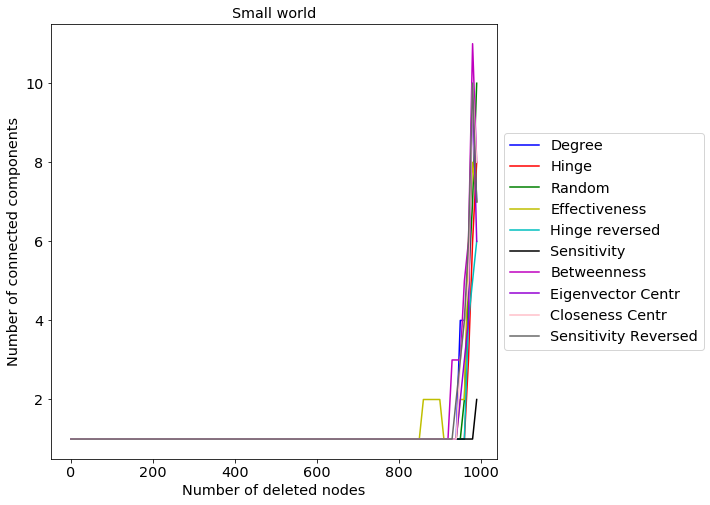

In [128]:
plot_sequential_deletion_num_of_comp(dd_sw,'Small world')

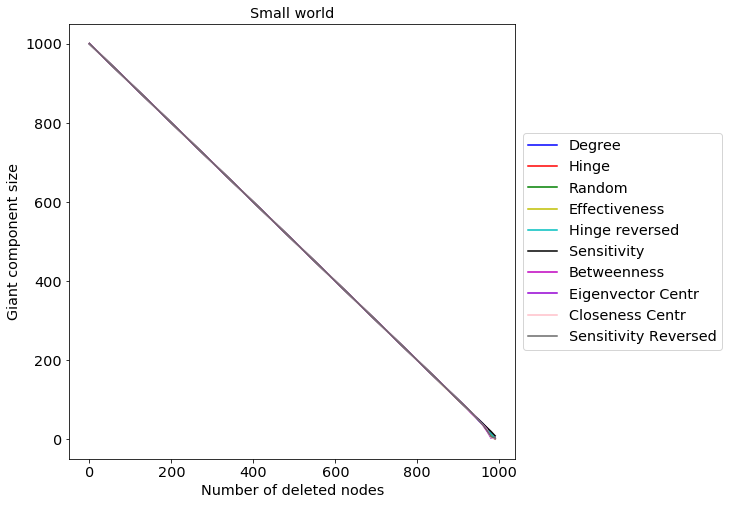

In [129]:
plot_sequential_deletion_gc_size(dd_sw,'Small world')

In [180]:
star = nx.star_graph(1000)
star.remove_edge(0,1)
star.remove_edge(0,2)
star.remove_edge(0,3)
star.remove_edge(0,4)
star.remove_edge(0,5)

star_df, star_gnm, star_prs_mat = get_gnm_df(star)


In [181]:
star_gnm.getEigvals()

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   

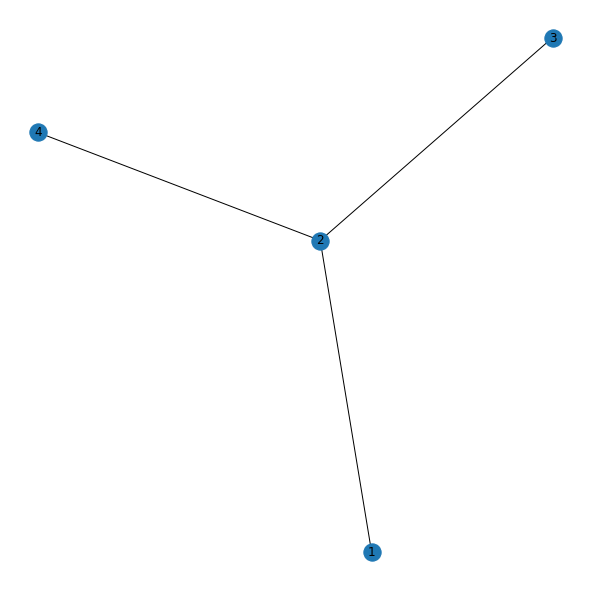

In [197]:
nx.draw(target,with_labels=True)

In [ ]:

g = nx.Graph()
g.add_edge(1,2);g.add_edge(1,3)
g.add_edge(1,7);g.add_edge(2,4)
g.add_edge(3,4);#g.add_edge(3,5)
g.add_edge(3,6);g.add_edge(4,5)
g.add_edge(5,6);g.add_edge(6,7)
import itertools

target = nx.Graph()
target.add_edge(1,2)
target.add_edge(2,3)
target.add_edge(2,4)


for sub_nodes in itertools.combinations(er.nodes(),len(target.nodes())):
    subg = er.subgraph(sub_nodes)
    if nx.is_connected(subg) and nx.is_isomorphic(subg, target):
        print(f"yes: {subg.edges()}")
#     else:
#         print(f"no: {subg.edges()}")


yes: [(0, 413), (1, 413), (20, 413)]
yes: [(0, 413), (1, 413), (413, 62)]
yes: [(0, 413), (1, 413), (76, 413)]
yes: [(0, 413), (1, 413), (90, 413)]
yes: [(0, 413), (1, 413), (120, 413)]
yes: [(0, 413), (1, 413), (132, 413)]
yes: [(0, 413), (1, 413), (413, 134)]
yes: [(0, 413), (1, 413), (164, 413)]
yes: [(0, 413), (1, 413), (165, 413)]
yes: [(0, 413), (1, 413), (213, 413)]
yes: [(0, 413), (1, 413), (218, 413)]
yes: [(0, 413), (1, 413), (234, 413)]
yes: [(0, 413), (1, 413), (252, 413)]
yes: [(0, 413), (1, 413), (413, 289)]
yes: [(0, 413), (1, 413), (322, 413)]
yes: [(0, 413), (1, 413), (413, 337)]
yes: [(0, 413), (1, 413), (362, 413)]
yes: [(0, 413), (1, 413), (373, 413)]
yes: [(0, 413), (1, 413), (441, 413)]
yes: [(0, 413), (1, 413), (413, 485)]
yes: [(0, 413), (1, 413), (492, 413)]
yes: [(0, 413), (1, 413), (413, 501)]
yes: [(0, 413), (1, 413), (413, 502)]
yes: [(0, 413), (1, 413), (413, 509)]
yes: [(0, 413), (1, 413), (516, 413)]
yes: [(0, 413), (1, 413), (525, 413)]
yes: [(0, 413), 

yes: [(0, 248), (248, 5), (248, 32)]
yes: [(0, 88), (88, 5), (88, 39)]
yes: [(0, 466), (466, 5), (466, 39)]
yes: [(0, 88), (88, 5), (88, 64)]
yes: [(0, 248), (248, 5), (248, 67)]
yes: [(0, 88), (73, 88), (88, 5)]
yes: [(0, 466), (466, 5), (466, 82)]
yes: [(0, 88), (88, 5), (88, 85)]
yes: [(0, 88), (88, 5), (88, 94)]
yes: [(0, 88), (109, 88), (88, 5)]
yes: [(0, 88), (137, 88), (88, 5)]
yes: [(0, 88), (152, 88), (88, 5)]
yes: [(0, 88), (88, 5), (88, 157)]
yes: [(0, 88), (88, 5), (88, 174)]
yes: [(0, 88), (88, 5), (88, 180)]
yes: [(0, 88), (88, 5), (88, 191)]
yes: [(0, 88), (88, 5), (88, 214)]
yes: [(0, 88), (88, 5), (88, 220)]
yes: [(0, 88), (225, 88), (88, 5)]
yes: [(0, 88), (226, 88), (88, 5)]
yes: [(0, 88), (275, 88), (88, 5)]
yes: [(0, 88), (281, 88), (88, 5)]
yes: [(0, 88), (88, 5), (88, 295)]
yes: [(0, 88), (301, 88), (88, 5)]
yes: [(0, 88), (410, 88), (88, 5)]
yes: [(0, 88), (88, 5), (88, 444)]
yes: [(0, 88), (477, 88), (88, 5)]
yes: [(0, 88), (513, 88), (88, 5)]
yes: [(0, 88), (5

yes: [(0, 8), (8, 13), (8, 771)]
yes: [(0, 8), (8, 13), (8, 783)]
yes: [(0, 8), (8, 13), (8, 802)]
yes: [(0, 8), (8, 13), (8, 823)]
yes: [(0, 8), (8, 13), (8, 847)]
yes: [(0, 8), (8, 13), (8, 849)]
yes: [(0, 8), (8, 13), (8, 858)]
yes: [(0, 8), (8, 13), (8, 876)]
yes: [(0, 8), (8, 13), (8, 883)]
yes: [(0, 8), (8, 13), (8, 891)]
yes: [(0, 8), (8, 13), (8, 906)]
yes: [(0, 8), (8, 13), (8, 924)]
yes: [(0, 8), (0, 25), (0, 35)]
yes: [(0, 8), (0, 25), (0, 50)]
yes: [(0, 8), (0, 25), (0, 81)]
yes: [(0, 8), (0, 25), (0, 88)]
yes: [(0, 8), (0, 25), (0, 91)]
yes: [(0, 8), (0, 25), (0, 105)]
yes: [(0, 8), (0, 25), (0, 112)]
yes: [(0, 8), (0, 25), (0, 167)]
yes: [(0, 8), (0, 25), (0, 194)]
yes: [(0, 8), (0, 25), (0, 229)]
yes: [(0, 8), (0, 25), (0, 230)]
yes: [(0, 8), (0, 25), (0, 248)]
yes: [(0, 8), (0, 25), (0, 250)]
yes: [(0, 8), (0, 25), (0, 265)]
yes: [(0, 8), (0, 25), (0, 313)]
yes: [(0, 8), (0, 25), (0, 355)]
yes: [(0, 8), (0, 25), (0, 411)]
yes: [(0, 8), (0, 25), (0, 413)]
yes: [(0, 8), (

yes: [(0, 8), (0, 88), (0, 105)]
yes: [(0, 8), (0, 88), (0, 112)]
yes: [(0, 8), (0, 88), (0, 167)]
yes: [(0, 8), (0, 88), (0, 229)]
yes: [(0, 8), (0, 88), (0, 230)]
yes: [(0, 8), (0, 88), (0, 248)]
yes: [(0, 8), (0, 88), (0, 250)]
yes: [(0, 8), (0, 88), (0, 265)]
yes: [(0, 8), (0, 88), (0, 313)]
yes: [(0, 8), (0, 88), (0, 355)]
yes: [(0, 8), (0, 88), (0, 411)]
yes: [(0, 8), (0, 88), (0, 413)]
yes: [(0, 8), (0, 88), (0, 418)]
yes: [(0, 8), (0, 88), (0, 419)]
yes: [(0, 8), (0, 88), (0, 454)]
yes: [(0, 8), (0, 88), (0, 456)]
yes: [(0, 8), (0, 88), (0, 460)]
yes: [(0, 8), (0, 88), (0, 484)]
yes: [(0, 8), (0, 88), (0, 521)]
yes: [(0, 8), (0, 88), (0, 537)]
yes: [(0, 8), (0, 88), (0, 570)]
yes: [(0, 8), (0, 88), (0, 577)]
yes: [(0, 8), (0, 88), (0, 611)]
yes: [(0, 8), (0, 88), (0, 613)]
yes: [(0, 8), (0, 88), (0, 659)]
yes: [(0, 8), (0, 88), (0, 665)]
yes: [(0, 8), (0, 88), (0, 684)]
yes: [(0, 8), (0, 88), (0, 702)]
yes: [(0, 8), (0, 88), (0, 713)]
yes: [(0, 8), (0, 88), (0, 731)]
yes: [(0, 

yes: [(0, 8), (0, 112), (0, 570)]
yes: [(0, 8), (0, 112), (0, 577)]
yes: [(0, 8), (0, 112), (0, 611)]
yes: [(0, 8), (0, 112), (0, 613)]
yes: [(0, 8), (0, 112), (0, 659)]
yes: [(0, 8), (0, 112), (0, 665)]
yes: [(0, 8), (0, 112), (0, 684)]
yes: [(0, 8), (0, 112), (0, 702)]
yes: [(0, 8), (0, 112), (0, 713)]
yes: [(0, 8), (0, 112), (0, 731)]
yes: [(0, 8), (0, 112), (0, 764)]
yes: [(0, 8), (0, 112), (0, 788)]
yes: [(0, 8), (0, 112), (0, 808)]
yes: [(0, 8), (0, 112), (0, 809)]
yes: [(0, 8), (0, 112), (0, 817)]
yes: [(0, 8), (0, 112), (0, 908)]
yes: [(0, 8), (0, 112), (0, 931)]
yes: [(0, 8), (0, 112), (0, 936)]
yes: [(0, 8), (0, 112), (0, 949)]
yes: [(0, 8), (8, 119), (8, 146)]
yes: [(0, 8), (8, 119), (8, 185)]
yes: [(0, 8), (8, 119), (8, 207)]
yes: [(0, 8), (8, 119), (8, 221)]
yes: [(0, 8), (8, 119), (8, 249)]
yes: [(0, 8), (8, 119), (8, 267)]
yes: [(0, 8), (8, 119), (8, 283)]
yes: [(0, 8), (8, 119), (8, 302)]
yes: [(0, 8), (8, 119), (8, 376)]
yes: [(0, 8), (8, 119), (8, 410)]
yes: [(0, 8), 

yes: [(0, 8), (0, 229), (0, 230)]
yes: [(0, 8), (0, 229), (0, 248)]
yes: [(0, 8), (0, 229), (0, 250)]
yes: [(0, 8), (0, 229), (0, 265)]
yes: [(0, 8), (0, 229), (0, 313)]
yes: [(0, 8), (0, 229), (0, 355)]
yes: [(0, 8), (0, 229), (0, 411)]
yes: [(0, 8), (0, 229), (0, 413)]
yes: [(0, 8), (0, 229), (0, 418)]
yes: [(0, 8), (0, 229), (0, 419)]
yes: [(0, 8), (0, 229), (0, 454)]
yes: [(0, 8), (0, 229), (0, 456)]
yes: [(0, 8), (0, 229), (0, 460)]
yes: [(0, 8), (0, 229), (0, 464)]
yes: [(0, 8), (0, 229), (0, 484)]
yes: [(0, 8), (0, 229), (0, 521)]
yes: [(0, 8), (0, 229), (0, 537)]
yes: [(0, 8), (0, 229), (0, 570)]
yes: [(0, 8), (0, 229), (0, 577)]
yes: [(0, 8), (0, 229), (0, 611)]
yes: [(0, 8), (0, 229), (0, 613)]
yes: [(0, 8), (0, 229), (0, 659)]
yes: [(0, 8), (0, 229), (0, 665)]
yes: [(0, 8), (0, 229), (0, 684)]
yes: [(0, 8), (0, 229), (0, 702)]
yes: [(0, 8), (0, 229), (0, 713)]
yes: [(0, 8), (0, 229), (0, 731)]
yes: [(0, 8), (0, 229), (0, 764)]
yes: [(0, 8), (0, 229), (0, 788)]
yes: [(0, 8), 

In [205]:
er